<a href="https://colab.research.google.com/github/safin92/serezha_safin/blob/main/Zadacha_2_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


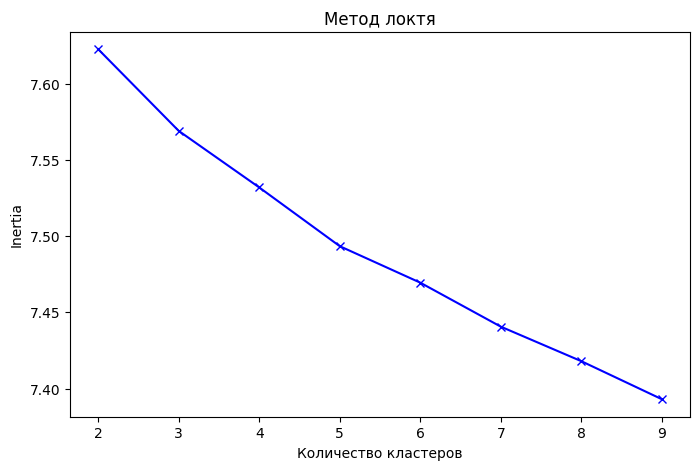

Silhouette Score: 0.007590995170176029


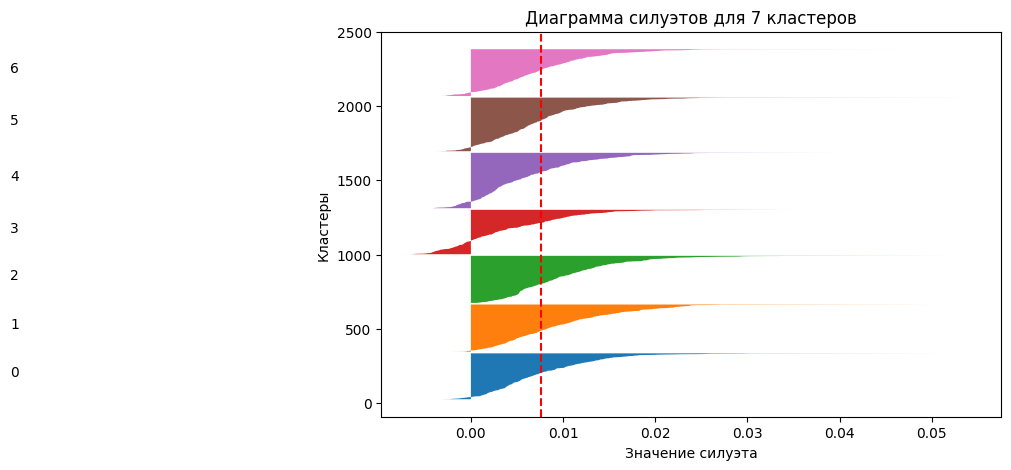

Новый документ относится к кластеру: 3


In [40]:
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Загрузка необходимых данных для nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Функция предобработки текста
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Приведение к нижнему регистру и токенизация
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha()]  # Лемматизация и удаление не букв
    tokens = [word for word in tokens if word not in stop_words]  # Удаление стоп-слов
    return tokens

# Функция для чтения всех .txt файлов из директории
def read_txt_files(folder_path):
    documents = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                text = file.read()
                processed_text = preprocess_text(text)  # Предобработка текста
                documents.append(processed_text)  # Добавляем токены
    return documents

extract_to = 'sample_texts'

# Чтение и предобработка всех .txt файлов из извлеченной директории
documents = read_txt_files(extract_to)

# Обучение модели Word2Vec
model = Word2Vec(sentences=documents, vector_size=100, window=5, min_count=1, workers=4)

# Получение векторов слов
word_vectors = model.wv.vectors

# Метод локтя для выбора количества кластеров
def plot_elbow_method(word_vectors):
    distortions = []
    K = range(2, 10)
    for k in K:
        kmeans_model = KMeans(n_clusters=k)
        kmeans_model.fit(word_vectors)
        distortions.append(kmeans_model.inertia_)

    # Построение графика метода локтя
    plt.figure(figsize=(8, 5))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Inertia')
    plt.title('Метод локтя')
    plt.show()

# Построение графика метода локтя
plot_elbow_method(word_vectors)

# Кластеризация с использованием KMeans
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(word_vectors)

# Получение предсказанных кластеров
clusters = kmeans.labels_

# Оценка кластеризации с использованием силуэта
silhouette_avg = silhouette_score(word_vectors, clusters)
print(f'Silhouette Score: {silhouette_avg}')

# Визуализация метрики силуэта
def plot_silhouette(word_vectors, labels, n_clusters):
    silhouette_vals = silhouette_samples(word_vectors, labels)

    y_lower = 25
    plt.figure(figsize=(8, 5))

    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()

        cluster_size = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + cluster_size

        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals)
        plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i))

        y_lower = y_upper + 10

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.xlabel('Значение силуэта')
    plt.ylabel('Кластеры')
    plt.title(f'Диаграмма силуэтов для {n_clusters} кластеров')
    plt.show()

# Построение графика силуэтов
plot_silhouette(word_vectors, clusters, n_clusters)

# Классификация новых документов
# Функция для получения вектора документа
def get_document_vector(model, text):
    tokens = preprocess_text(text)
    word_vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(word_vectors) == 0:  # Если нет векторов, вернем нулевой вектор
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# Новый текст
new_document = "Privet"
new_embedding = get_document_vector(model, new_document)

# Поиск ближайшего кластера
nearest_neighbors = NearestNeighbors(n_neighbors=1, metric='cosine').fit(word_vectors)
_, indices = nearest_neighbors.kneighbors([new_embedding])

# Определение ближайшего кластера
nearest_cluster = clusters[indices[0][0]]
print(f'Новый документ относится к кластеру: {nearest_cluster}')